<h2> Toxic Comments Classification</h2>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split


https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [ ]:
train_df = pd.read_csv(path+'train.csv').fillna(' ')
train_df.sample(5, random_state=1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0


In [ ]:
train_df.loc[train_df['toxic']==1].sample(5, random_state=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
30575,512e03958d8615e4,"""\n Are you asking if we would ever block some...",1,0,0,0,0,0
36038,60506a63b56bc539,Amen my sock-pupinski brother!! Hack-a-long: p...,1,0,0,0,0,0
19730,341c484d858e4441,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1,0,1,0,0,0
72261,c1723b16ec5d9979,u no wat ass hole go fuck your self and stop b...,1,0,1,0,1,0
77923,d0a55e6ffaa62b3d,Go fuck yourself \n\nEat shit and die. 68.0.11...,1,1,1,1,1,0


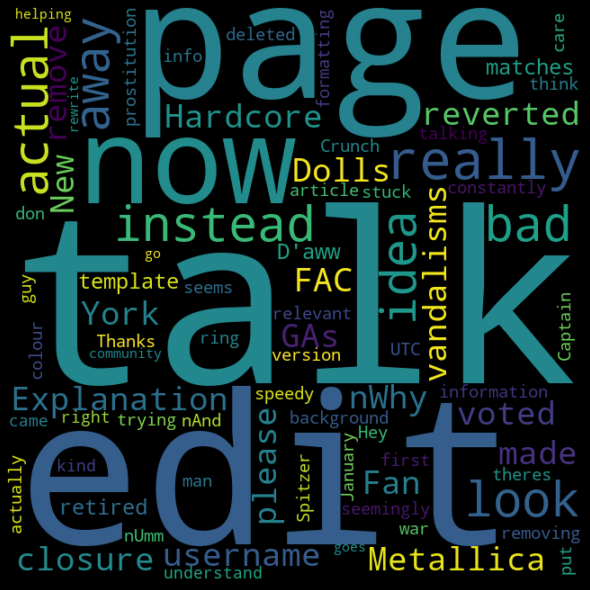

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
txt = train_df['comment_text'].loc[train_df['toxic']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(txt))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

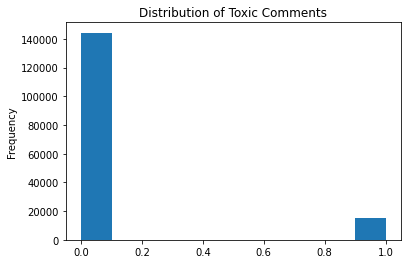

In [ ]:
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments');

In [ ]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [ ]:
x = train_df['comment_text'].values
y = train_df['toxic'].values

##Tokenize and Pad Text Data

https://cezannec.github.io/CNN_Text_Classification/

In [ ]:
max_features = 20000
max_text_length = 400

In [ ]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x) 
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

##Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [ ]:
# Download and extract GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-04-23 23:40:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-23 23:40:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-23 23:40:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embedding_dims = 100
embeddings_index = dict()
f = open(path+'glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_features, embedding_dims))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

##Create Embedding Layer

In [ ]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

###Build the Model

In [ ]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [ ]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##Train Model

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1)

In [ ]:
batch_size = 32
epochs = 3

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 76s 10ms/step - loss: 0.1665 - accuracy: 0.9405 - val_loss: 0.1162 - val_accuracy: 0.9561
Epoch 2/3
4239/4239 [==============================] - 43s 10ms/step - loss: 0.1213 - accuracy: 0.9551 - val_loss: 0.1173 - val_accuracy: 0.9573
Epoch 3/3
4239/4239 [==============================] - 44s 10ms/step - loss: 0.1078 - accuracy: 0.9594 - val_loss: 0.1077 - val_accuracy: 0.9605


##Evaluate Model

In [ ]:
model.evaluate(x_val, y_val, batch_size=128)

187/187 [==============================] - 3s 14ms/step - loss: 0.1077 - accuracy: 0.9605


[0.10765550285577774, 0.9604779481887817]

In [ ]:
test_df = pd.read_csv(path+'test.csv')

In [ ]:
x_test = test_df['comment_text'].values

In [ ]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [ ]:
y_testing = model.predict(x_testing, verbose = 1, batch_size=32)

4787/4787 [==============================] - 21s 4ms/step


In [ ]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
